# **Question 1a**

### **Importing the Crucial Libraries**

In [ ]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
from google.colab import drive, files

# Data Processing
import nltk
import spacy
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pydotplus
from sklearn import tree
from IPython.display import Image

# Data Augmentation
import random
!pip install nlpaug
import nlpaug.augmenter.word as naw

# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay

### **Import dataset**

In [ ]:
# Mount google drive
drive.mount('/content/drive')

# Load the dataset
data_dir = "/content/drive/MyDrive/Colab Notebooks/DAML Assignment/mentalhealth.csv"
df = pd.read_csv(data_dir, header=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Explore the Dataset**

In [ ]:
# Look at the shape of dataset
print(df.shape)

# Checking out the data types
print(df.info())

(53047, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53047 entries, 0 to 53046
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53044 non-null  object
 1   statement   52681 non-null  object
 2   status      53016 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB
None


In [ ]:
# Overview of the dataset
print(df.head(), "\n")
print(df.tail())

  Unnamed: 0                                          statement   status
0          0                                         oh my gosh  Anxiety
1          1  trouble sleeping, confused mind, restless hear...  Anxiety
2          2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3          3  I've shifted my focus to something else but I'...  Anxiety
4          4  I'm restless and restless, it's been a month n...  Anxiety 

      Unnamed: 0                                          statement   status
53042      53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53043      53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53044      53040  Is there any way to sleep better? I can't slee...  Anxiety
53045      53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53046      53042  I have really bad door anxiety! It's not about...  Anxiety


### **Missing Values**

**Checking the missing values**

In [ ]:
df_clean = df.copy()

# Total of missing values
print(df_clean.isnull().sum())

# Which columns contain missing values
missing_rows = df_clean[df_clean.isnull().any(axis=1)]
print("\nRows with missing values: ")
missing_rows

Unnamed: 0      3
statement     366
status         31
dtype: int64

Rows with missing values: 


,Unnamed: 0,statement,status
6,6,"I feel scared, anxious, what can I do? And may...",NaN
7,7,Have you ever felt nervous but didn't know why?,NaN
8,8,"I haven't slept well for 2 days, it's like I'm...",NaN
293,293,NaN,Anxiety
572,572,NaN,Anxiety
...,...,...,...
52940,52936,NaN,Anxiety
53014,53010,NaN,Anxiety
53035,53031,NaN,Anxiety
53040,53036,someone help me think rationally I know I soun...,NaN


**rows with at least 2 missing values**

In [ ]:
# Identify if there are rows that contain more than one missing values
missing_rows_two = df_clean.loc[:, 'Unnamed:0':'status'].isnull().sum(axis=1) >=2

# Filter and display the rows
df_with_two_missing = df_clean[missing_rows_two]

print("Rows that contain at least two missing values:")
df_with_two_missing

Rows that contain at least two missing values:


,Unnamed: 0,statement,status
13294,NaN,NaN,NaN
13295,NaN,NaN,NaN
13296,NaN,NaN,NaN
13297,Suicidal,NaN,NaN


In [ ]:
# Fix the misalignment issue
# Relocate the status 'Suicidal' back to row 13293
df_clean.loc[13293, 'status'] = 'Suicidal'

# Drop empty gap rows (where 'statement' and 'status' column are empty)
df_clean = df_clean.dropna(subset=['statement', 'status'], how='all')

# Check again if empty gaps are removed
df_clean.loc[13290:13300]

,Unnamed: 0,statement,status
13290,13290,"tw: death""Existential dread"" I have heard the ...",Depression
13291,13291,You once dreamed of being a writer. You once d...,Suicidal
13292,13292,I play college soccer which is my only accompl...,Suicidal
13293,13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal
13298,13294,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Depression
13299,13295,Oh Why are there so many members of this commu...,Suicidal
13300,13296,"I am going through a divorce right now, I was ...",Depression


In [ ]:
# Print the shape to check the dataset
print("Original dataset shape:", df.shape)
print("Cleaned dataset shape:", df_clean.shape)

Original dataset shape: (53047, 3)
Cleaned dataset shape: (53043, 3)


**Drop the initial index before imputation**

In [ ]:
# Drop the initial index
df_clean = df_clean.drop(columns=['Unnamed: 0'])
df_clean

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53042,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53043,"selfishness ""I don't feel very good, it's lik...",Anxiety
53044,Is there any way to sleep better? I can't slee...,Anxiety
53045,"Public speaking tips? Hi, all. I have to give ...",Anxiety


**Mode imputation**

In [ ]:
# Impute missing values for 'statement' column
df_clean['statement'] = df_clean.apply(
    lambda row: row['statement'] if pd.notna(row['statement'])  # If 'statement' is filled, make no changes
    else (
        row['statement'] if pd.isna(row['status'])  # If 'status' is missing, make no changes
        # If 'status' is filled, impute mode 'statement' according to 'status' group
        else df_clean[df_clean['status'] == row['status']]['statement'].mode()[0]
    ),axis=1
)

# Check for any missing values after imputation
df_clean.isna().sum()

,0
statement,0
status,26


In [ ]:
# Calculate the overall mode of the 'status' column
status_mode = df_clean['status'].mode()[0]

# Impute missing 'status' values with the overall mode
df_clean['status'] = df_clean['status'].fillna(status_mode)

# Check for any missing values after imputation
df_clean.isna().sum()

,0
statement,0
status,0


**Download the cleaned dataset**

In [ ]:
# Download cleaned dataset
df_clean.to_csv('mentalhealth_cleaned.csv', index=False)
files.download('mentalhealth_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Text Preprocessing - Stopwords and Special Characters Removal**

In [ ]:
# Set vocabulary size and sequence length
vocab_size = 5000
max_len = 100

In [ ]:
# Download stopwords if not already available
nltk.download("stopwords")

# Load spaCy model for stopwords
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = nlp.Defaults.stop_words

important_words = {
    'like', 'feel', 'want', 'know', 'get', 'life', 'im', 'even', 'time', 'would',
    'really', 'people', 'cannot', 'one', 'going', 'think', 'go', 'much', 'never', 'day',
    'help', 'dont', 'things', 'could', 'years', 'anymore', 'anxiety', 'back', 'work', 'anything',
    'still', 'make', 'something', 'depression', 'got', 'friends', 'always', 'good', 'take', 'anyone',
    'feeling', 'way', 'everything', 'ive', 'better', 'every', 'need', 'see', 'also', 'happy','fulfilled','break','nervous','death','hate'
}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    """Preprocesses text by removing special characters, numbers & stopwords while keeping important words."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters & numbers
    words = text.split()

    # Keep words that are either NOT stopwords OR in the important words list
    filtered_words = [word for word in words if (word not in stop_words) or (word in important_words)]

    return " ".join(filtered_words)  # Join back into a sentence

# Apply preprocessing
df_clean["cleaned_statement"] = df_clean["statement"].astype(str).apply(preprocess_text)

In [ ]:
# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_clean["cleaned_statement"])

# Convert text to sequences and pad them
df_clean["padded_statement"] = list(pad_sequences(
    tokenizer.texts_to_sequences(df_clean["cleaned_statement"]),
    maxlen=max_len,
    padding='post',
    truncating='post'
))

# Display processed data
df_clean[["statement", "cleaned_statement", "padded_statement"]].head()

,statement,cleaned_statement,padded_statement
0,oh my gosh,oh gosh,"[428, 4471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,"[731, 464, 754, 138, 1005, 165, 1, 0, 0, 0, 0,..."
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...,"[141, 29, 1971, 414, 918, 204, 1005, 1005, 157..."
3,I've shifted my focus to something else but I'...,ive shifted focus something im still worried,"[45, 1, 513, 34, 8, 32, 262, 0, 0, 0, 0, 0, 0,..."
4,"I'm restless and restless, it's been a month n...",im restless restless month boy mean,"[8, 1005, 1005, 158, 1129, 222, 0, 0, 0, 0, 0,..."


# **Question 1b**

### **Identify Categories**

In [ ]:
# Identify and count total columns of each category
sentiment_count = df_clean['status'].value_counts().sort_values(ascending=True)
sentiment_count

,count
status,
Personality disorder,1199
Stress,2669
Bipolar,2873
Anxiety,3881
Suicidal,10648
Depression,15399
Normal,16374


<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

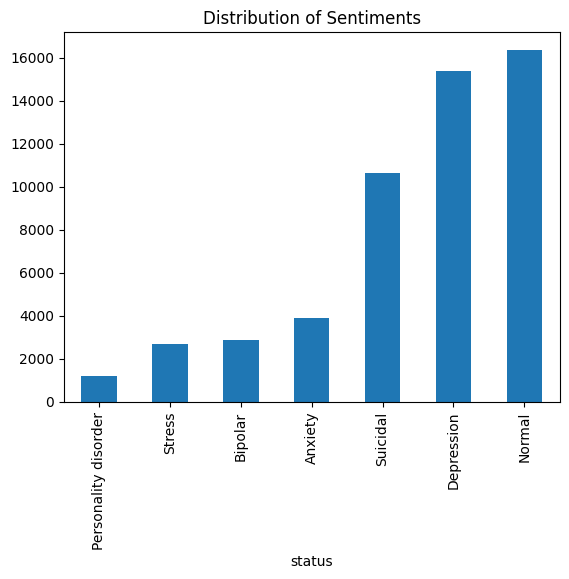

In [ ]:
# Plot the Distribution of Sentiments
sentiment_count.plot(kind='bar', title='Distribution of Sentiments')

### **Binary Classfication**

In [ ]:
# Transform 'Status' into binary classification
status_map = {
  'Normal': 'Normal',
  'Depression': 'Depression',
  'Suicidal': 'Depression',
  'Anxiety': 'Depression',
  'Stress': 'Depression',
  'Bipolar': 'Depression',
  'Personality disorder': 'Depression'
 }

# Map 'status' column with the new classification
df_clean['status'] = df_clean['status'].map(status_map)

# Check the new category
df_clean['status'].value_counts().sort_values(ascending=True)

,count
status,
Normal,16374
Depression,36669


# **Question 2**

### **Convert Categorical Variable to Numerical**

In [ ]:
# Use Label Encoding to convert categorical variable
df_clean['status'] = df_clean['status'].map({'Normal': 0, 'Depression': 1})
df_clean.head(10)

,statement,status,cleaned_statement,padded_statement
0,oh my gosh,1,oh gosh,"[428, 4471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"trouble sleeping, confused mind, restless hear...",1,trouble sleeping confused mind restless heart ...,"[731, 464, 754, 138, 1005, 165, 1, 0, 0, 0, 0,..."
2,"All wrong, back off dear, forward doubt. Stay ...",1,wrong back dear forward doubt stay restless re...,"[141, 29, 1971, 414, 918, 204, 1005, 1005, 157..."
3,I've shifted my focus to something else but I'...,1,ive shifted focus something im still worried,"[45, 1, 513, 34, 8, 32, 262, 0, 0, 0, 0, 0, 0,..."
4,"I'm restless and restless, it's been a month n...",1,im restless restless month boy mean,"[8, 1005, 1005, 158, 1129, 222, 0, 0, 0, 0, 0,..."
5,"every break, you must be nervous, like somethi...",1,every break nervous like something wrong heck,"[48, 274, 639, 2, 34, 141, 3056, 0, 0, 0, 0, 0..."
6,"I feel scared, anxious, what can I do? And may...",0,feel scared anxious family protected,"[3, 128, 214, 54, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,Have you ever felt nervous but didn't know why?,0,felt nervous didnt know,"[83, 639, 173, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
8,"I haven't slept well for 2 days, it's like I'm...",0,havent slept days like im restless huh,"[369, 1120, 87, 2, 8, 1005, 2862, 0, 0, 0, 0, ..."
9,"I'm really worried, I want to cry.",1,im really worried want cry,"[8, 12, 262, 4, 232, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


### **Shuffling the cleaned Data**

In [ ]:
df_shuffled = shuffle(df_clean, random_state=42)

# Display the first few rows of the shuffled DataFrame
df_shuffled.head()

,statement,status,cleaned_statement,padded_statement
22265,Just as the the title says. I feel like one is...,1,title says feel like one hyper alot attention ...,"[951, 313, 3, 2, 15, 2618, 1033, 535, 3713, 1,..."
41404,a blackened sky encroached tugging behind it m...,1,blackened sky encroached tugging depression,"[1, 2760, 1, 1, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20069,"It gives you insomnia, which in turn makes you...",1,gives insomnia turn makes depression worse day...,"[740, 1498, 377, 111, 35, 98, 21, 1, 97, 9, 74..."
30040,"Hello all, I'm a new submitter to this channel...",0,hello im new submitter channel went nights ago...,"[614, 8, 101, 1, 3609, 104, 1025, 95, 229, 623..."
780,Thank God the CB is over for Eid,0,thank god cb eid,"[268, 279, 3852, 2125, 0, 0, 0, 0, 0, 0, 0, 0,..."


### **Data Splitting**

In [ ]:
# Extract features (padded sequences) and labels
X = df_shuffled["padded_statement"].tolist()  # Convert padded sequences to a list
y = df_shuffled["status"]  # Target labels

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 42434
Testing set size: 10609


### **Decision Tree Model**

In [ ]:
# Train Decision Tree Classifier
clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight={0: 1, 1: 4},  # Increase weight for class 1
    random_state=42
)

clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 13059, 1: 29375}


**Graphing the decision tree**

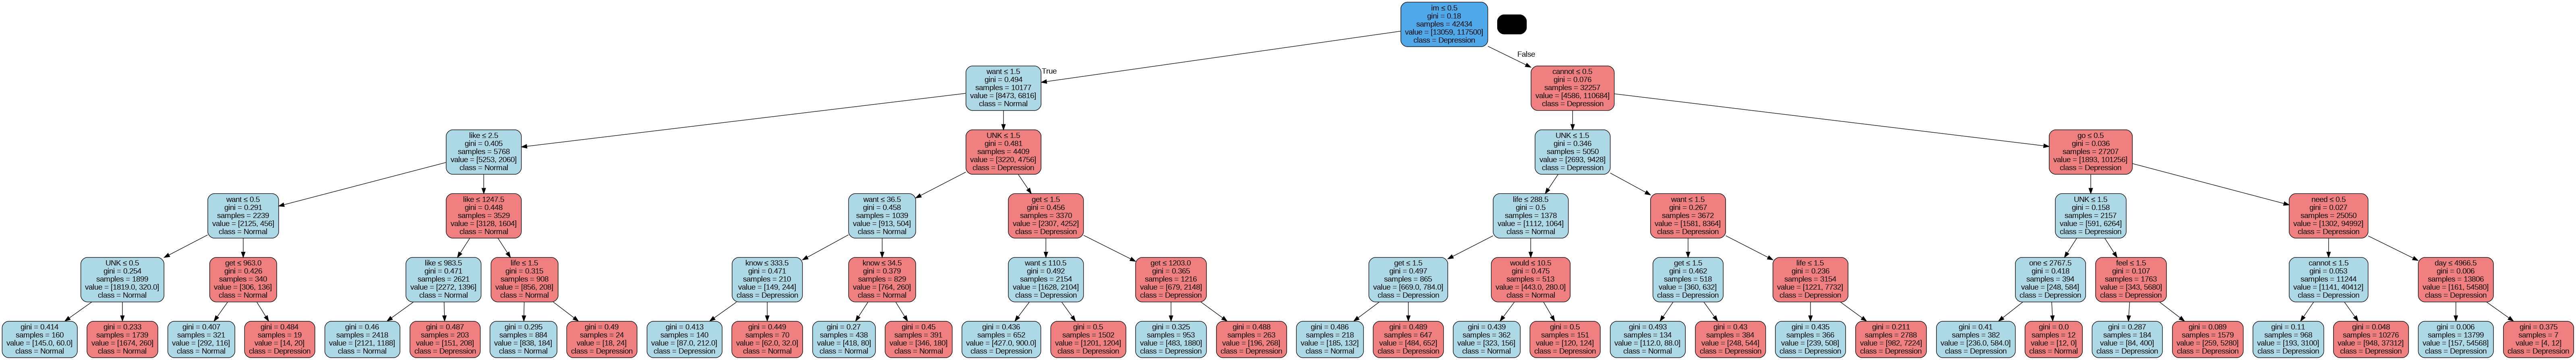

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Ensure feature names match the number of features in the trained model
n_features = clf.n_features_in_  # Get the number of features in the model
index_to_word = {index: word for word, index in tokenizer.word_index.items()}
data_feature_names = list(index_to_word.values())[:n_features]

data_feature_names = [word if word != "<OOV>" else "UNK" for word in data_feature_names]

# Verify the number of feature names matches the model
assert len(data_feature_names) == n_features, f"Feature names ({len(data_feature_names)}) do not match model features ({n_features})"

# Generate the DOT data for visualization
dot_data = tree.export_graphviz(
    clf,  # Decision Tree model
    feature_names=[str(feature) for feature in data_feature_names],  # Tokenized words
    class_names=['Normal', 'Depression'],  # Target labels
    out_file=None,
    filled=True,
    rounded=True,
    special_characters=True
)

# Convert to a graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Define colors for classification outcomes (Normal vs Depression)
colors = ('lightblue', 'lightcoral')  # Blue for Normal, Coral for Depression
edges = collections.defaultdict(list)

# Iterate through graph edges
for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

# Sort and apply colors
for edge in edges:
    edges[edge].sort()
    for i in range(len(edges[edge])):  # Dynamic handling for multiple edges
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i % len(colors)])  # Cycle colors

# Save the Decision Tree visualization as an image
graph.write_png('/content/DecisionTree_Prediction.png')

# Display the Decision Tree image in Colab
display(Image('/content/DecisionTree_Prediction.png'))

# Optional: Download the image
files.download('/content/DecisionTree_Prediction.png')


### **Neural Network Model**

In [ ]:
# Define the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    GaussianNoise(0.15),  # Balanced noise for smoother training

    LSTM(10, return_sequences=False, kernel_regularizer=l2(0.002)),  # Moderate LSTM size
    BatchNormalization(),
    Dropout(0.55),  # Slightly higher dropout to slow learning

    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.002))
])

# Slightly lower learning rate
optimizer = Adam(learning_rate=0.0002)

# Label smoothing to prevent overconfidence
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks for controlled learning
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Increase patience


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **Data Augmentation**

In [ ]:
nltk.download("averaged_perceptron_tagger_eng")

# Define text augmentation methods
syn_aug = naw.SynonymAug(aug_src="wordnet")  # Synonym Replacement
swap_aug = naw.RandomWordAug(action="swap")  # Random Word Swap
delete_aug = naw.RandomWordAug(action="delete")  # Random Deletion

def augment_text(text):
    # Applies a random augmentation technique to the given text.
    aug = random.choice([syn_aug, swap_aug, delete_aug])
    return aug.augment(text)

# Apply augmentation to the cleaned text
augmented_texts = [augment_text(text) for text in df_shuffled["cleaned_statement"].astype(str).tolist()]

# Convert both original and augmented text to sequences and pad them
x_train_padded = pad_sequences(tokenizer.texts_to_sequences(df_shuffled["cleaned_statement"]), maxlen=max_len, padding="post", truncating="post")
x_aug_padded = pad_sequences(tokenizer.texts_to_sequences(augmented_texts), maxlen=max_len, padding="post", truncating="post")

# Combine original and augmented data
X_train_combined = np.vstack([x_train_padded, x_aug_padded])
y_train_combined = np.concatenate([y_train, y_train])  # Duplicate labels for augmented data

print("Original Sample:", X_train[0])
print("Augmented Sample:", augmented_texts[0])

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Original Sample: [ 119  445    1    2   61 1271  119  445  545    1    1    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Augmented Sample: ['says like one alot attention whore idealistic stupid normal realist wants kill one witch somtimes usually seconds time stop controlling make look idiot insane like tell normal depressed mental disease thanks feel one hates']


**Training the model**

In [ ]:
# Check distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
print("Training Data Distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count}")

# Check distribution in testing set
unique, counts = np.unique(y_test, return_counts=True)
print("\nTesting Data Distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count}")

Training Data Distribution:
Class 0: 13059
Class 1: 29375

Testing Data Distribution:
Class 0: 3315
Class 1: 7294


In [ ]:
# Train the model
history = model.fit(np.array(X_train), y_train, epochs=50, batch_size=64, callbacks=[early_stopping], validation_data=(np.array(X_test), y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(np.array(X_test), y_test)
print("\nTest Accuracy:", test_acc)

Epoch 1/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5383 - loss: 0.9619 - val_accuracy: 0.4803 - val_loss: 0.7152
Epoch 2/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5730 - loss: 0.7312 - val_accuracy: 0.5900 - val_loss: 0.6317
Epoch 3/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7352 - loss: 0.5774 - val_accuracy: 0.9016 - val_loss: 0.3626
Epoch 4/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8917 - loss: 0.4129 - val_accuracy: 0.9232 - val_loss: 0.3185
Epoch 5/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9153 - loss: 0.3662 - val_accuracy: 0.9355 - val_loss: 0.2947
Epoch 6/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9263 - loss: 0.3373 - val_accuracy: 0.9060 - val_loss: 0.3230
Epoch 7/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9320 - loss: 0.3198 - val_accuracy: 0.9287 - val_loss: 0.2956
Epoch 8/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9368 - loss: 0.3069 - val_

**Graphing the performance**

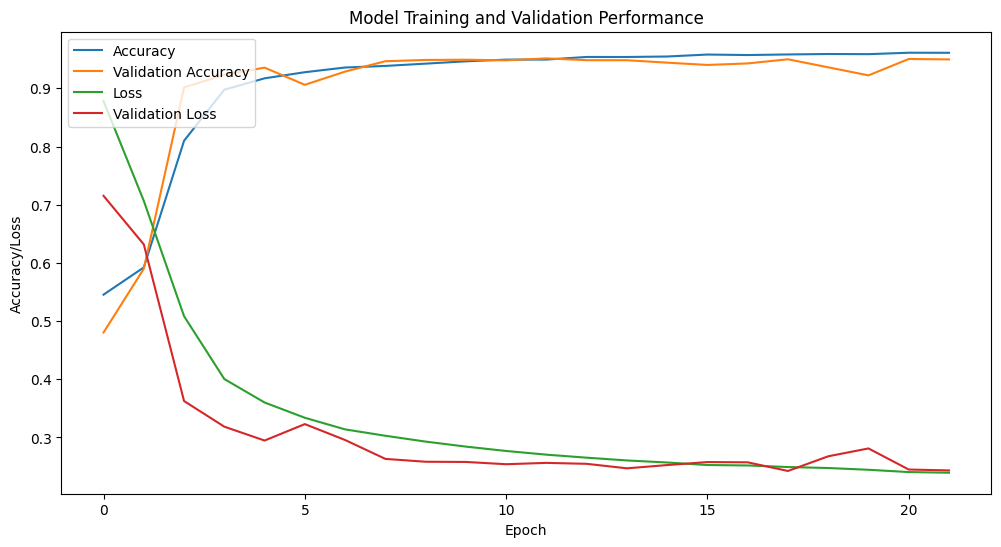

In [ ]:
# Assuming 'history' is the training history object from model.fit()
plt.figure(figsize=(12, 6))  # Adjust figure size if needed

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Training and Validation Performance')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss'], loc='upper left')

plt.show()

# **Question 3a**

### **Computing the Performance Metrics**

In [ ]:
# Make predictions for both models
y_pred_tree = clf.predict(X_test)  # Decision Tree Model Predictions

# Convert X_test to NumPy array with correct shape for Neural Network
X_test_nn = np.array(X_test)

y_pred_nn = model.predict(X_test_nn)  # Neural Network Predictions

# Convert NN predictions to binary labels (Threshold = 0.5)
y_pred_nn_binary = (y_pred_nn >= 0.5).astype(int)

332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### **Plotting the accuracy of Decision Tree & Neural Network**

In [ ]:
# Calculate metrics
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"--- {name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(classification_report(y_true, y_pred))
    print("\n")

# Evaluate both models
evaluate_model("Decision Tree", y_test, y_pred_tree)
evaluate_model("Neural Network", y_test, y_pred_nn_binary)

--- Decision Tree Performance ---
Accuracy: 0.8250
Precision: 0.8092
Recall: 0.9753
              precision    recall  f1-score   support

           0       0.90      0.49      0.64      3315
           1       0.81      0.98      0.88      7294

    accuracy                           0.82     10609
   macro avg       0.86      0.73      0.76     10609
weighted avg       0.84      0.82      0.81     10609



--- Neural Network Performance ---
Accuracy: 0.9499
Precision: 0.9529
Recall: 0.9753
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      3315
           1       0.95      0.98      0.96      7294

    accuracy                           0.95     10609
   macro avg       0.95      0.93      0.94     10609
weighted avg       0.95      0.95      0.95     10609





### **Confusion Matrix**

In [ ]:
# Predictions for Decision Tree
y_pred_tree = clf.predict(X_test)

# Predictions for Neural Network (Convert probabilities to binary)
y_pred_nn = model.predict(np.array(X_test)) # Convert X_test to a NumPy array
y_pred_nn_binary = (y_pred_nn >= 0.5).astype(int)

# Compute confusion matrices
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_nn = confusion_matrix(y_test, y_pred_nn_binary)

332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 500x400 with 0 Axes>

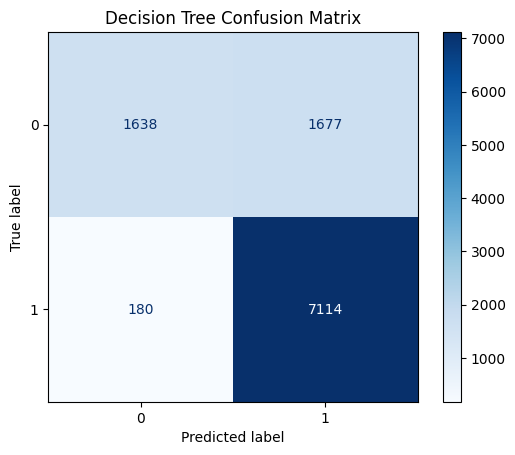

<Figure size 500x400 with 0 Axes>

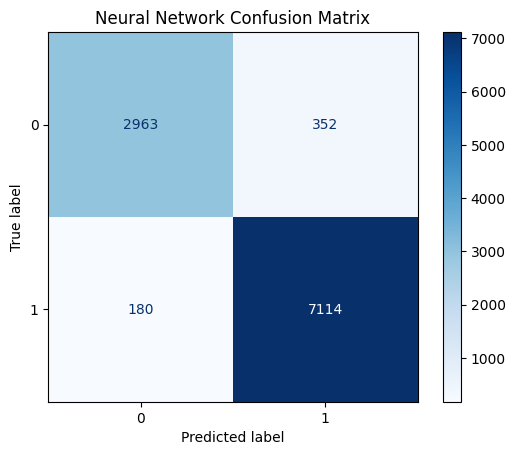

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(5, 4))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

# Plot for Decision Tree
plot_confusion_matrix(cm_tree, "Decision Tree Confusion Matrix")

# Plot for Neural Network
plot_confusion_matrix(cm_nn, "Neural Network Confusion Matrix")

# **Question 3b**

### **Plotting ROC and AUC of Decision Tree & Neural Network**

In [ ]:
# Compute ROC curve & AUC
fpr_tree, tpr_tree, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
auc_tree = auc(fpr_tree, tpr_tree)

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)  # No need to use proba, NN outputs sigmoid
auc_nn = auc(fpr_nn, tpr_nn)

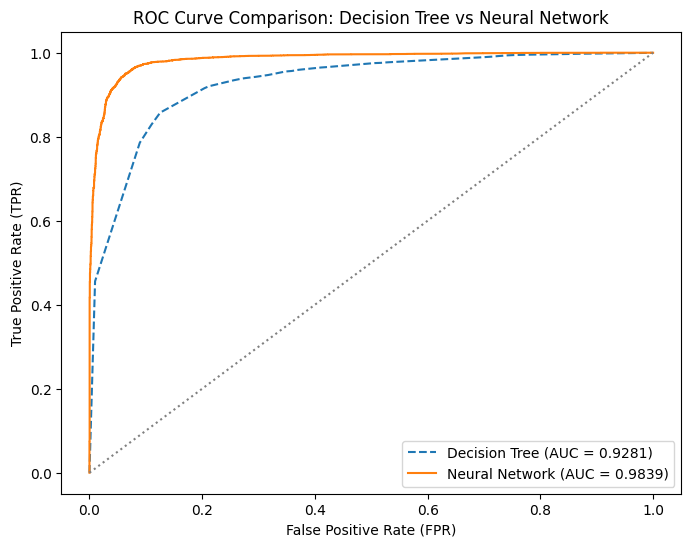

In [ ]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {auc_tree:.4f})", linestyle="--")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.4f})", linestyle="-")

# Reference line for random classifier
plt.plot([0, 1], [0, 1], color="gray", linestyle="dotted")

# Labels and legend
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison: Decision Tree vs Neural Network")
plt.legend()
plt.show()

# **Question 4**

**Testing -  Decision Tree**

In [ ]:
# Example input texts
new_texts = [
    "I can't stop worrying about everything",
    "I've been working hard, and seeing the results makes me feel incredibly happy and fulfilled",
    "Even the smallest things feel like too much right now",
    "I can’t stop smiling",
    "Today has been amazing!"
]

# Preprocess each text
cleaned_texts = [preprocess_text(text) for text in new_texts]

# Convert text to sequences
new_texts_sequences = tokenizer.texts_to_sequences(cleaned_texts)

# Pad sequences to match model's input shape
new_texts_padded = pad_sequences(new_texts_sequences, maxlen=max_len, padding='post', truncating='post')

# Ensure input format is correct (convert to list if needed)
new_texts_padded = new_texts_padded.tolist()

# Make predictions using the trained model
predictions = clf.predict(new_texts_padded)  # Get predictions for all statements
probabilities = clf.predict_proba(new_texts_padded)  # Get probabilities

# Print results
for i, text in enumerate(new_texts):
    print(f"\nStatement: {text}")
    print("Prediction Probabilities:", probabilities[i])

    if predictions[i] >= 0.5:
        print("Prediction: The person may have Depression (1).")
    else:
        print("Prediction: The person is Normal (0).")


Statement: I can't stop worrying about everything
Prediction Probabilities: [0.32177845 0.67822155]
Prediction: The person may have Depression (1).

Statement: I've been working hard, and seeing the results makes me feel incredibly happy and fulfilled
Prediction Probabilities: [0.11966854 0.88033146]
Prediction: The person may have Depression (1).

Statement: Even the smallest things feel like too much right now
Prediction Probabilities: [0.20440118 0.79559882]
Prediction: The person may have Depression (1).

Statement: I can’t stop smiling
Prediction Probabilities: [0.64097915 0.35902085]
Prediction: The person is Normal (0).

Statement: Today has been amazing!
Prediction Probabilities: [0.64097915 0.35902085]
Prediction: The person is Normal (0).


**Testing - Neural Networks**

In [ ]:
# Example input texts
new_texts = [
    "I can't stop worrying about everything",
    "I've been working hard, and seeing the results makes me feel incredibly happy and fulfilled",
    "Even the smallest things feel like too much right now",
    "I can’t stop smiling",
    "Today has been amazing!"
]

# Preprocess each text
cleaned_texts = [preprocess_text(text) for text in new_texts]

# Convert texts to sequences
new_texts_sequences = tokenizer.texts_to_sequences(cleaned_texts)

# Pad sequences to match model's input shape
new_texts_padded = pad_sequences(new_texts_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert to NumPy array before prediction
new_texts_padded = np.array(new_texts_padded)

# Make predictions using the trained model
predictions = model.predict(new_texts_padded)  # Get predictions for all statements

# Print results
for i, text in enumerate(new_texts):
    prob = predictions[i][0]  # Extract probability
    print(f"\nStatement: {text}")
    print("Prediction Probability:", prob)

    # Output classification
    if prob >= 0.7:  # Threshold set to 0.7 for classifying depression
        print("Prediction: The person may have Depression (1).")
    else:
        print("Prediction: The person is Normal (0).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Statement: I can't stop worrying about everything
Prediction Probability: 0.83109164
Prediction: The person may have Depression (1).

Statement: I've been working hard, and seeing the results makes me feel incredibly happy and fulfilled
Prediction Probability: 0.6544109
Prediction: The person is Normal (0).

Statement: Even the smallest things feel like too much right now
Prediction Probability: 0.772475
Prediction: The person may have Depression (1).

Statement: I can’t stop smiling
Prediction Probability: 0.15198001
Prediction: The person is Normal (0).

Statement: Today has been amazing!
Prediction Probability: 0.037440002
Prediction: The person is Normal (0).
